In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/S27FE-10K.csv")

In [3]:
FEATURES_TO_DROP = [
    'realized_volatility',  # the target
    'Unnamed: 0',           # an index-like column
    'stock_id',             # or any ID columns you want to exclude
]

X = df.drop(columns=FEATURES_TO_DROP, errors='ignore')
y = df['realized_volatility']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Scale your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [4]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 16  # Bottleneck dimension

# Input
input_layer = keras.Input(shape=(input_dim,), name="input")

# Dense layers (with bottleneck in the middle)
x = layers.Dense(32, activation='relu')(input_layer)
x = layers.Dense(encoding_dim, activation='relu', name="bottleneck")(x)  
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='linear')(x)

# Build & compile
model = keras.Model(inputs=input_layer, outputs=output_layer, name="supervised_bottleneck")
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "supervised_bottleneck"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,705 (10.57 KB)

 Trainable params: 2,705 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=10,       # Increase/decrease as needed
    batch_size=256,  # Adjust as needed
    verbose=1
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0939 - val_loss: 0.0148
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - val_loss: 0.0061
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0102e-04 - val_loss: 0.0010
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7694e-04 - val_loss: 8.4505e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2950e-04 - val_loss: 7.1302e-04


In [7]:
bottleneck_extractor = keras.Model(
    inputs=model.input,
    outputs=model.get_layer("bottleneck").output
)

X_train_encoded = bottleneck_extractor.predict(X_train_scaled)
X_test_encoded  = bottleneck_extractor.predict(X_test_scaled)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


In [8]:
mlp_input_dim = X_train_encoded.shape[1]

mlp_input = keras.Input(shape=(mlp_input_dim,), name="mlp_input")
x = layers.Dense(32, activation='relu')(mlp_input)
x = layers.Dense(16, activation='relu')(x)
mlp_output = layers.Dense(1, activation='linear')(x)

regressor = keras.Model(inputs=mlp_input, outputs=mlp_output, name="regressor")
regressor.compile(optimizer='adam', loss='mse')  # for volatility, MSE is common

regressor.summary()

history_mlp = regressor.fit(
    X_train_encoded, y_train,
    validation_data=(X_test_encoded, y_test),
    epochs=10,            # adjust
    batch_size=256,       # adjust
    verbose=1
)

Model: "regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mlp_input (InputLayer)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0028
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8905e-04 - val_loss: 6.6862e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0358e-04 - val_loss: 5.0692e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 4.4019e-04 - val_loss: 4.1530e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4548e-04 - val_loss: 3.5198e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0501e-04 - val_loss: 3.0655e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6798e-04 - val_loss: 2.7249e-04
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2230e-04 - val_loss: 2.3622e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8695e-04 - val_loss: 2.1286e-04


In [9]:
y_pred = regressor.predict(X_test_encoded)

# For example, compute MSE or R^2:
from sklearn.metrics import mean_squared_error, r2_score
mse  = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"MLP on Autoencoder Encoded Features - MSE: {mse:.4f}  R^2: {r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
MLP on Autoencoder Encoded Features - MSE: 0.0002  R^2: -60.9558


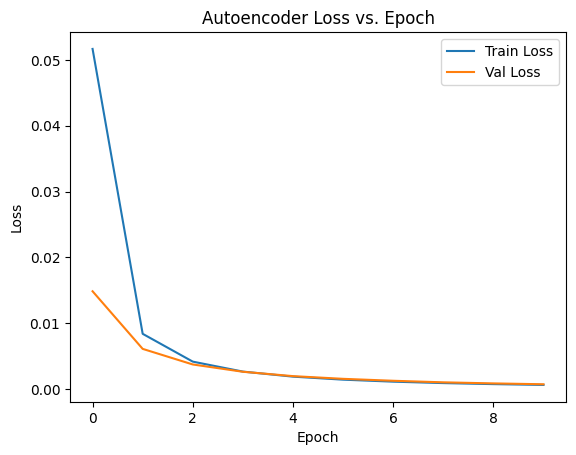

In [11]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

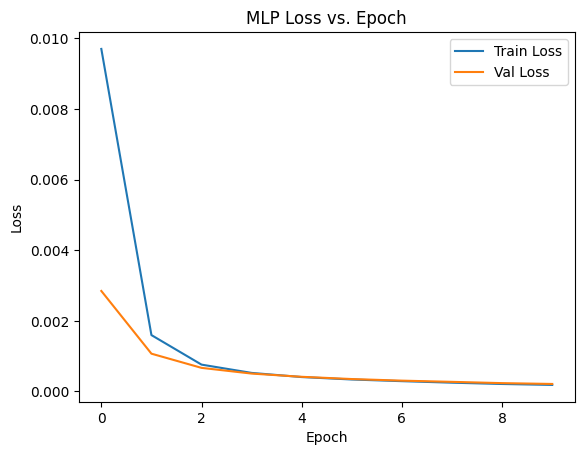

In [12]:
plt.figure()
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Val Loss')
plt.title('MLP Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

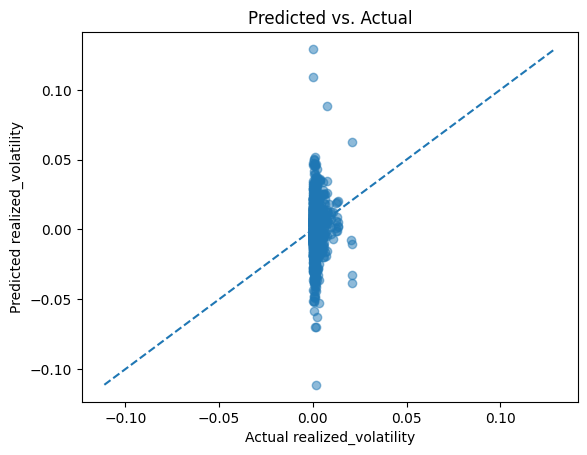

In [13]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual realized_volatility')
plt.ylabel('Predicted realized_volatility')
# Optionally draw a 45-degree line for reference
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.show()

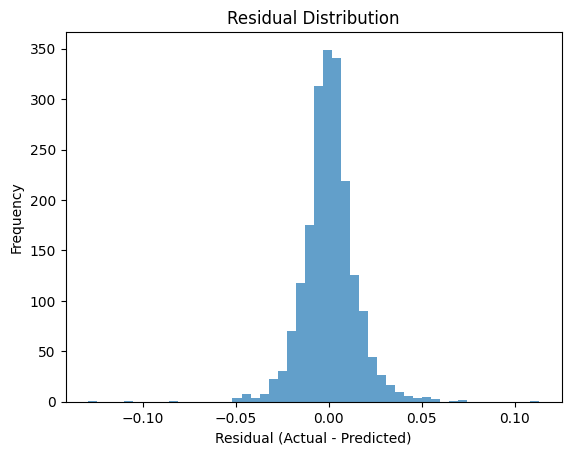

In [14]:
residuals = y_test.values - y_pred.flatten()

plt.figure()
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()